In [ ]:
import gym_envs
import gymnasium as gym
env = gym.make('gym_envs/TicTacToe-v0')

state, info = env.reset()
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
env.render()
state, reward, terminated, truncated, info = env.step(0)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(4)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(3)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(6)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(2)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(1)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(7)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(8)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(5)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
print("Truncated:", truncated)
env.render()


env.reset()
state, reward, terminated, truncated, info = env.step(0)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(3)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(7)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(4)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(2)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(6)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(1)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Reward:", reward)



In [ ]:
class NormalizeZeroToOne(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_high = self.env.observation_space.high
        self.observation_low = self.env.observation_space.low

    def observation(self, obs):
        print(obs)
        print((obs - self.observation_low) / (self.observation_high - self.observation_low))
        return (obs - self.observation_low) / (self.observation_high - self.observation_low)

In [ ]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)

    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)

In [ ]:
# env = gym.wrappers.AtariPreprocessing(gym.make("ALE/MsPacman-v5", render_mode="rgb_array"), terminal_on_life_loss=True, scale_obs=True) # as seen online with frame stackign though
# env = gym.wrappers.AtariPreprocessing(gym.make("ALE/MsPacman-v5", render_mode="rgb_array"), terminal_on_life_loss=True, scale_obs=True) # as seen online
env = ClipReward(gym.wrappers.AtariPreprocessing(gym.make("MsPacmanNoFrameskip-v4", render_mode="rgb_array"), terminal_on_life_loss=True), -1, 1) # as recommended by the original paper, should already include max pooling
env = gym.wrappers.FrameStack(env, 4)

In [ ]:
from rainbow_agent import RainbowAgent
import gymnasium as gym
import numpy as np
import tensorflow as tf
from hyperopt import hp

In [ ]:
def create_search_space():
    search_space = {
        "activation": hp.choice(
            "activation",
            [
                "linear",
                "relu",
                # 'relu6',
                "sigmoid",
                "softplus",
                "soft_sign",
                "silu",
                "swish",
                "log_sigmoid",
                "hard_sigmoid",
                # 'hard_silu',
                # 'hard_swish',
                # 'hard_tanh',
                "elu",
                # 'celu',
                "selu",
                "gelu",
                # 'glu'
            ],
        ),
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "lecun_uniform",
                "lecun_normal",
                "orthogonal",
                "variance_baseline",
                "variance_0.1",
                "variance_0.3",
                "variance_0.8",
                "variance_3",
                "variance_5",
                "variance_10",
            ],
        ),
        "optimizer": hp.choice(
            "optimizer", [tf.keras.optimizers.legacy.Adam]
        ),  # NO SGD OR RMSPROP FOR NOW SINCE IT IS FOR RAINBOW DQN
        "learning_rate": hp.choice(
            "learning_rate", [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),  #
        "adam_epsilon": hp.choice(
            "adam_epsilon",
            [1, 0.5, 0.3125, 0.03125, 0.003125, 0.0003125, 0.00003125, 0.000003125],
        ),
        "clipnorm": hp.choice("clipnorm", [None]),
        # NORMALIZATION?
        "soft_update": hp.choice(
            "soft_update", [False]
        ),  # seems to always be false, we can try it with tru
        "ema_beta": hp.uniform("ema_beta", 0.95, 0.999),
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "replay_interval": hp.choice("replay_interval", [1, 2, 3, 4, 5, 8, 10, 12]),
        "minibatch_size": hp.choice(
            "minibatch_size", [2**i for i in range(0, 8)]
        ),  ###########
        "replay_buffer_size": hp.choice(
            "replay_buffer_size", [2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000, 50000]
        ),  #############
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size", [0, 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000]
        ),  # 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000
        "n_step": hp.choice("n_step", [1, 2, 3, 4, 5, 8, 10]),
        "discount_factor": hp.choice(
            "discount_factor", [0.1, 0.5, 0.9, 0.99, 0.995, 0.999]
        ),
        "atom_size": hp.choice("atom_size", [11, 21, 31, 41, 51, 61, 71, 81]),  #
        "conv_layers": hp.choice("conv_layers", [[], [(32, 8, 4), (64, 4, 2), (64, 3, 1)]]),
        "conv_layers_noisy": hp.choice("conv_layers_noisy", [False]),
        "width": hp.choice("width", [32, 64, 128, 256, 512, 1024]),
        "dense_layers": hp.choice("dense_layers", [0, 1, 2, 3, 4]),
        "dense_layers_noisy": hp.choice(
            "dense_layers_noisy", [True]
        ),  # i think this is always true for rainbow
        # REWARD CLIPPING
        "noisy_sigma": hp.choice("noisy_sigma", [0.5]),  #
        "loss_function": hp.choice(
            "loss_function",
            [tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.KLDivergence()],
        ),
        "dueling": hp.choice("dueling", [True]),
        "advantage_hidden_layers": hp.choice(
            "advantage_hidden_layers", [0, 1, 2, 3, 4]
        ),  #
        "value_hidden_layers": hp.choice("value_hidden_layers", [0, 1, 2, 3, 4]),  #
        "training_steps": hp.choice("training_steps", [30000]),
        "per_epsilon": hp.choice(
            "per_epsilon", [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
        ),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(0, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
        "v_min": hp.choice("v_min", [-500.0]),  # MIN GAME SCORE
        "v_max": hp.choice("v_max", [500.0]),  # MAX GAME SCORE
        # 'search_max_depth': 5,
        # 'search_max_time': 10,
        "training_iterations": hp.choice("training_iterations", [1, 2, 3, 4, 5]),
        "num_minibatches": hp.choice("num_minibatches", [1, 2, 3, 4, 5]),
    }
    initial_best_config = [
        {
            "activation": 1,
            "kernel_initializer": 6,
            "optimizer": 0,  # NO SGD OR RMSPROP FOR NOW SINCE IT IS FOR RAINBOW DQN
            "learning_rate": 5,  #
            "adam_epsilon": 5,
            "clipnorm": 0,
            # NORMALIZATION?
            "soft_update": 0,  # seems to always be false, we can try it with tru
            "ema_beta": 0.95,
            "transfer_interval": 3,
            "replay_interval": 1,
            "minibatch_size": 7,
            "replay_buffer_size": 8,  
            "min_replay_buffer_size": 4,
            "n_step": 2,
            "discount_factor": 3,
            "atom_size": 4,  #
            "conv_layers": 0,
            "conv_layers_noisy": 0,
            "width": 4,
            "dense_layers": 2,
            "dense_layers_noisy": 0,  # i think this is always true for rainbow
            # REWARD CLIPPING
            "noisy_sigma": 0,  #
            "loss_function": 0,
            "dueling": 0,
            "advantage_hidden_layers": 0,  #
            "value_hidden_layers": 0,  #
            "training_steps": 0,
            "per_epsilon": 3,
            "per_alpha": 10,
            "per_beta": 7,
            # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
            "v_min": 0,  # MIN GAME SCORE
            "v_max": 0,  # MAX GAME SCORE
            # 'search_max_depth': 5,
            # 'search_max_time': 10,
            "training_iterations": 0,
            "num_minibatches": 0,
        }
    ]

    return search_space, initial_best_config


In [ ]:
from hyperopt import space_eval

search_sapce, initial_best_config = create_search_space()
config = space_eval(search_sapce, initial_best_config[0])
print(config)


In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [ ]:
from agent_configs import RainbowConfig
from game_configs import CartPoleConfig
config = RainbowConfig(config, CartPoleConfig())
# train
agent = RainbowAgent(env, config, "RainbowDQN-{}".format(env.unwrapped.spec.id))
agent.train()

In [7]:
import gymnasium as gym
import gym_anytrading

env = gym.make('forex-v0')
# env = gym.make('stocks-v0')


In [8]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

custom_env = gym.make(
    'forex-v0',
    df=FOREX_EURUSD_1H_ASK,
    window_size=10,
    frame_bound=(10, 300),
    unit_side='right'
)

# custom_env = gym.make(
#     'stocks-v0',
#     df=STOCKS_GOOGL,
#     window_size=10,
#     frame_bound=(10, 300)
# )


In [9]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("custom_env information:")
print("> shape:", custom_env.unwrapped.shape)
print("> df.shape:", custom_env.unwrapped.df.shape)
print("> prices.shape:", custom_env.unwrapped.prices.shape)
print("> signal_features.shape:", custom_env.unwrapped.signal_features.shape)
print("> max_possible_profit:", custom_env.unwrapped.max_possible_profit())


env information:
> shape: (24, 2)
> df.shape: (6225, 5)
> prices.shape: (6225,)
> signal_features.shape: (6225, 2)
> max_possible_profit: 4.054407219413578

custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1228998536878634


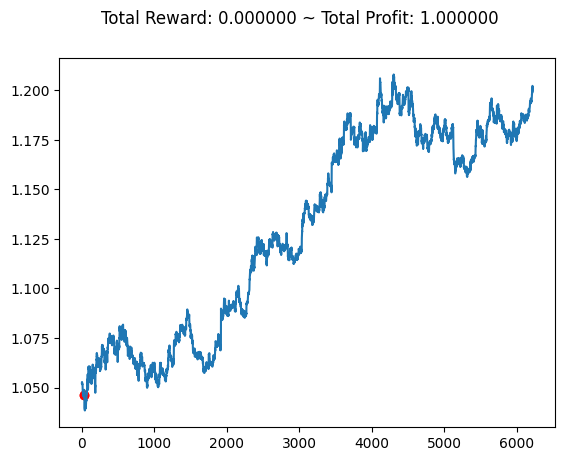

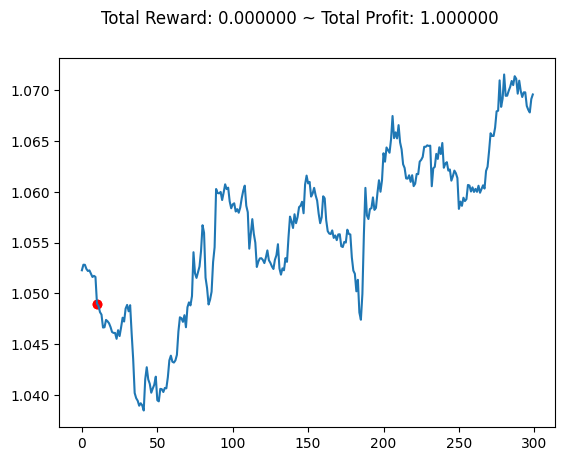

In [17]:
observation, info = env.reset()
env.render()

env = custom_env
observation, info = env.reset()
env.render()

Using default adam_epsilon: 1e-06
Using default learning_rate: 0.01
Using default optimizer: <class 'keras.src.optimizers.adam.Adam'>
Using loss_function: <keras.src.losses.KLDivergence object at 0x2f2e0cc70>
Using default training_iterations: 1
Using default num_minibatches: 1
Using default minibatch_size: 32
Using default replay_buffer_size: 1024
Using min_replay_buffer_size: 32
Using default training_steps: 10000
Using activation: relu
Using kernel_initializer: orthogonal
Using default width: 128
Using default noisy_sigma: 0.5
Using default conv_layers: []
Using default conv_layers_noisy: False
Using default dense_layers: 1
Using default dense_layers_noisy: False
Using default value_hidden_layers: 0
Using default advantage_hidden_layers: 0
Using default discount_factor: 0.99
Using default soft_update: False
Using default transfer_interval: 512
Using default ema_beta: 0.99
Using default replay_interval: 4
Using default per_alpha: 0.6
Using default per_beta: 0.5
Using default per_epsi

Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1

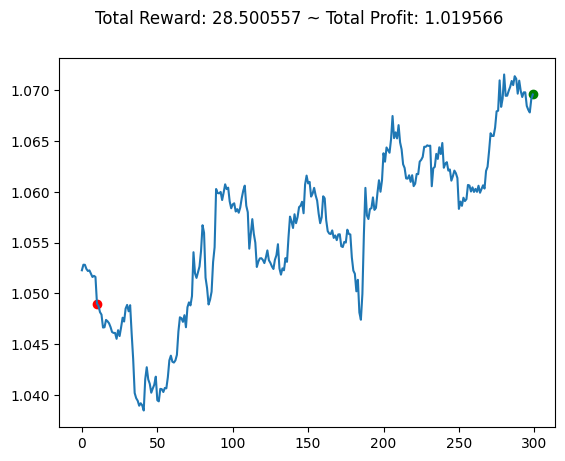

Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0
Action:  0

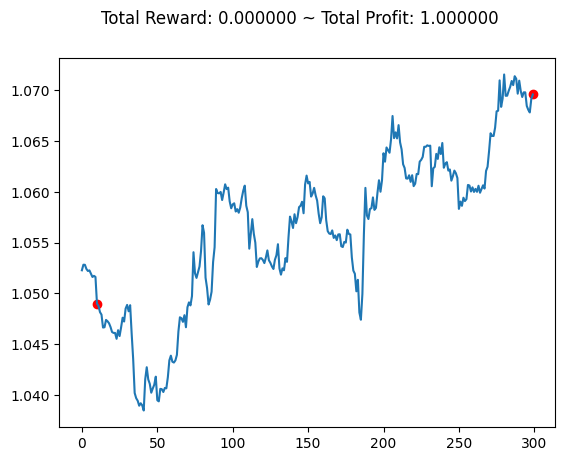

Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1

KeyboardInterrupt: 

In [18]:
from rainbow_agent import RainbowAgent
from agent_configs import RainbowConfig
from game_configs import CartPoleConfig
config_dict = {
    "activation": "relu",
    "kernel_initializer": "orthogonal",
    "min_replay_buffer_size": 32,
    "loss_function": tf.keras.losses.KLDivergence(),
}
config = RainbowConfig(config_dict, CartPoleConfig())
# train
agent = RainbowAgent(env, config, "RainbowDQN-{}".format(env.unwrapped.spec.id))
agent.train()